# 1. Análisis del Problema

Este cuaderno presenta el problema de Machine Learning que se pretende resolver y realiza el análisis exploratorio de los datos para finalmente elegir la estategia de preparación del dataset que se utilizará para entrenar los modelos posteriores.
Está organizado como un procedimiento en las siguientes secciones:

1. **Descripción del problema**
2. **Análisis Exploratorio de Datos**
3. **Ingeniería de Features**
4. **Conclusiones y lineamientos para desarrollo de modelos.**


## 1.1 Descripción del problema

Dado un [dataset de operaciones con tarjetas de crédito (fuente:Kaggle)](https://www.kaggle.com/mlg-ulb/creditcardfraud) que tiene etiquetadas aquellas que fueron identificadas como fraude, interesa elaborar un modelo que permita clasificar automáticamente nuevas operaciones.

Como ejercicio, se propone también desplegar este modelo en un esquema de microservicios para poder hacer un monitoreo en tiempo real utilizando herramientas COTS.

#### Dataset

El dataset original contiene:

- **Información temporal**: Los segundos transcurridos desde la primer operación registrada en el dataset. El tiempo inicial real es desconocido. Dado que este campo no se utiliza, se asignó una fecha arbitraria sólo con la finalidad de visualizar los datos en herramientas que soportan la búsqueda por indexado temporal (ejemplos: Grafana y Kibana).
- **Features v1-v28**: de acuerdo a la descripción del dataset, características resultantes de haber aplicado PCA para proteger la identidad de los usuarios y capturar aquellas de mayor relevancia para el problema.
- **Monto de la operación**
- **Resultado de la clasificación**: 0=No fraude, 1=Fraude.

#### Alcance y Limitaciones

- Si bien está disponible la información temporal, los modelos estudiados en este trabajo tratarán el problema como si se tratara de eventos aislados. Están fuera del alcance RNNs, u otros algoritmos que utilicen información temporal.
- Se asume que las nuevas operaciones han pasado por el mismo proceso de PCA que el dataset original. Como este proceso es desconocido en este ejercicio, se particionará el dataset en un lote de datos para desarrollo del modelo (entrenamiento o entrenamiento/validación dependiendo del caso) y otro lote para evaluación.

## 1.2 Análisis exploratorio de los datos

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import joblib

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

TMP_PATH = "./tmp/" # Path temporal usado para imágenes generadas, archivos intermedios, etc.
MODELS_PATH = "/models/"

In [2]:
DATASET_FILENAME_PATH = "/data/credit_fraud/creditcard.csv"

def load_credit_fraud_from_csv(path=DATASET_FILENAME_PATH):
    col_names = [ "time" ]
    col_names.extend(["v{}".format(x) for x in range(1,28)])
    col_names.append( "amount" )
    col_names.append( "class" )
    return pd.read_csv(DATASET_FILENAME_PATH,skiprows=1,index_col=0, names=col_names)

In [3]:
df = load_credit_fraud_from_csv()

A continuación se hará una exploración inicial del dataset.

In [4]:
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v20,v21,v22,v23,v24,v25,v26,v27,amount,class
0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Vista de tipos de datos de columnas (nota: los campos de interés ya han sido convertidos a Float previamente).

In [5]:
df.dtypes

time      float64
v1        float64
v2        float64
v3        float64
v4        float64
v5        float64
v6        float64
v7        float64
v8        float64
v9        float64
v10       float64
v11       float64
v12       float64
v13       float64
v14       float64
v15       float64
v16       float64
v17       float64
v18       float64
v19       float64
v20       float64
v21       float64
v22       float64
v23       float64
v24       float64
v25       float64
v26       float64
v27       float64
amount    float64
class       int64
dtype: object

Estadísticas generales.

In [6]:
df.describe()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v20,v21,v22,v23,v24,v25,v26,v27,amount,class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Distribución de clases. 

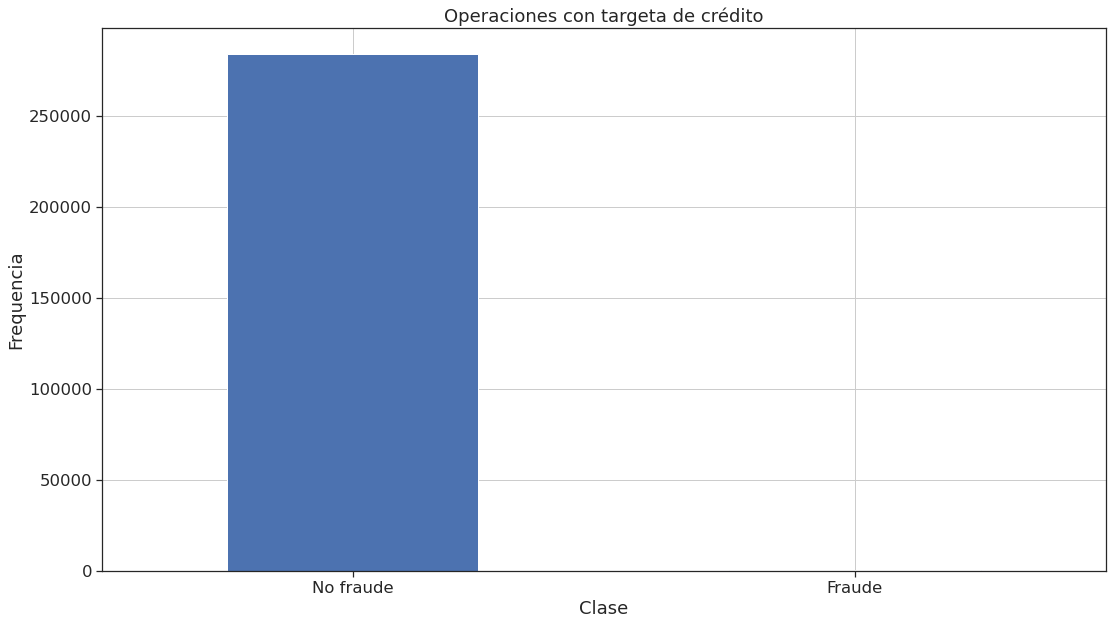

In [7]:
count_classes = pd.value_counts(df['class'], sort = True)
plt.figure(figsize=(18,10))
count_classes.plot(kind = 'bar', rot=0)
plt.title("Operaciones con targeta de crédito")
plt.xticks(range(2), ["No fraude", "Fraude"])
plt.grid(which="Both")
plt.xlabel("Clase")
plt.ylabel("Frequencia")
plt.show()

Lo primero que se observa es que el dataset está fuertemente desbalanceado. Esto representa un problema que se tratará en la etapa siguiente de preprocesamiento.
Se estudiará también la distribución por clases en el tiempo.

*Nota*: en el gráfico a continuación el eje vertical está en escala logarítmica.

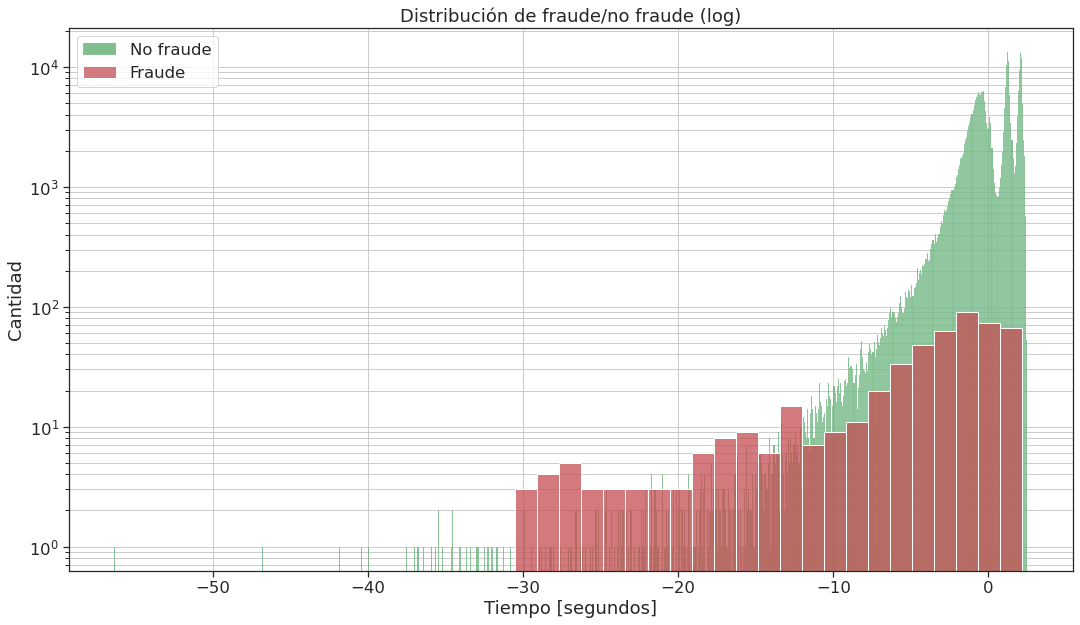

In [8]:
def plot_class_distribution_in_time(df, title,log=False):
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(18,10))
    ax.set_title(title)
    sns.histplot(df[df['class']==0]['time']-df.time.min()/1000, color='g', label='No fraude',ax=ax) 
    sns.histplot(df[df['class']==1]['time']-df.time.min()/1000, color='r', label='Fraude',ax=ax) 
    ax.grid(which="Both")
    if log:
        ax.set_yscale('log')
    ax.legend(["No fraude","Fraude"])
    plt.xlabel("Tiempo [segundos]")
    plt.ylabel("Cantidad")
    
plot_class_distribution_in_time(df,title='Distribución de fraude/no fraude (log)',log=True)

### 1.2.1 Preprocesamiento de dataset

#### 1.2.1.1 Manejo de datos inválidos

Este dataset, al igual que muchos descargados de Kaggle, ya fue previamente procesado y no contiene filas con NaNs.

In [10]:
ds_with_nans = df.loc[df.isna().sum(axis=1)>=1,:]
ds_without_nans = df.loc[df.isna().sum(axis=1)==0,:]
print("Filas con NaNs:{}".format(ds_with_nans.shape[0]))
print("Filas sin NaNs: {}".format(ds_without_nans.shape[0]))

Filas con NaNs:0
Filas sin NaNs: 284807


#### 1.2.1.2 Manejo de datos imbalanceados.

Como se observó en el análisis exploratorio inicial, los datos están fuertemente desbalanceados en favor de los casos no fraudulentos (esto es esperableen los problemas de detección de fallas/anomalías).
Aquí se pueden adoptar distintas estrategias:
1. **Upsampling**: aumentar la cantidad de muestras de la clase minoritaria (agregando muestras reales o artificiales).
2. **Downsampling**: reducir la cantidad de muestras de la clase mayoritaria.
3. **Seleccionar cuidadosamente la métrica de evaluación**: no hacer nada en la preparación del dataset, y elegir una métrica de performance adecuada para este escenario (TPR/TNR/AUC/Precision/Recall/etc.)

Para continuar con este análisis trabajando con datos originales se procederá con la segunda opción, pero en la preparación de datos se hará también un remuestreo agregando muestras sintéticas y en la evaluación se utilizará una métrica apropiada.

In [9]:
from sklearn.utils import resample

In [10]:
df_majority = df[df['class']==0]
df_minority = df[df['class']==1]

In [12]:
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=123)

In [13]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled['class'].value_counts()

1    492
0    492
Name: class, dtype: int64

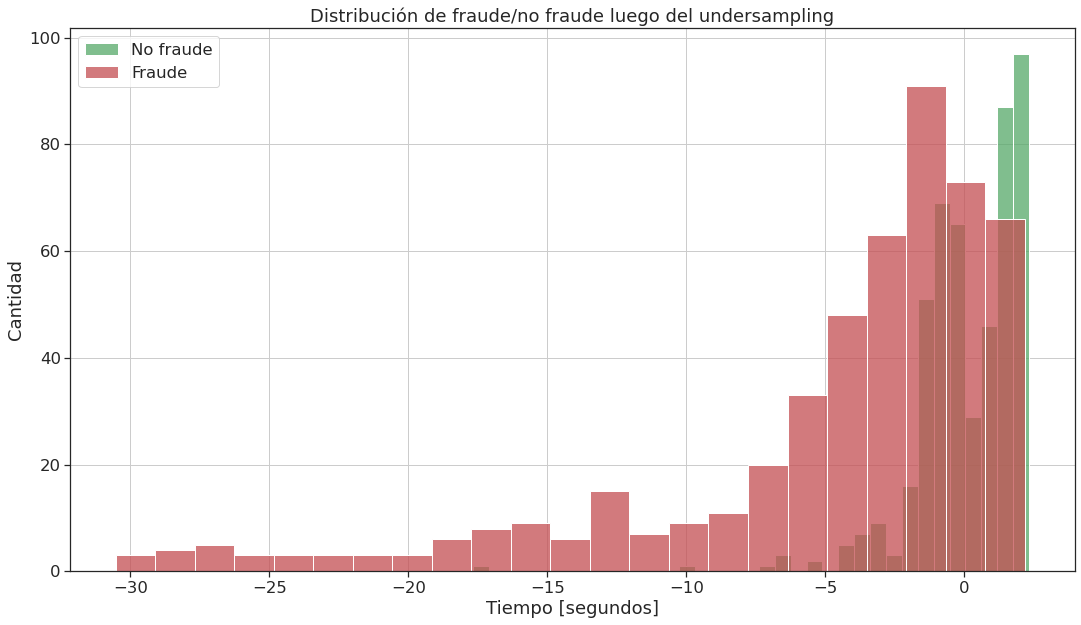

In [14]:
plot_class_distribution_in_time(df_downsampled,title='Distribución de fraude/no fraude luego del undersampling',
                                log=False)

In [15]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [16]:
non_feature_cols = ['time','row_id','class']
feature_cols = [x for x in df.columns if x not in non_feature_cols]
feature_cols

['v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'v7',
 'v8',
 'v9',
 'v10',
 'v11',
 'v12',
 'v13',
 'v14',
 'v15',
 'v16',
 'v17',
 'v18',
 'v19',
 'v20',
 'v21',
 'v22',
 'v23',
 'v24',
 'v25',
 'v26',
 'v27',
 'amount']

In [17]:
X = df_downsampled[feature_cols]
y = df_downsampled['class']

In [18]:
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=1)

## 1.3 Ingeniería de Features

### 1.3.1 Análisis por correlación

En este análisis se intentará saber cuales son las características con una mayor influencia en una operación identificada como fraudulenta utilizando el coeficiente de correlación de Pearson. Es importante tener presente que en este análisis aún cuando una característica puede parecer no ser relevante, combinada con otra (u otras) sí podría serlo, y este aspecto pasaría desapercibido. Por lo tanto, no se deben descartar variables sólo porque exhiban un bajo coeficiente de correlación.

In [19]:
exclude_corr_cols = ['time','row_id'] # Exluímos el tiempo y el número de fila.
corr_cols = [x for x in df_downsampled.columns if x not in exclude_corr_cols]
df_downsampled_train = pd.concat([X_train, y_train], axis=1)

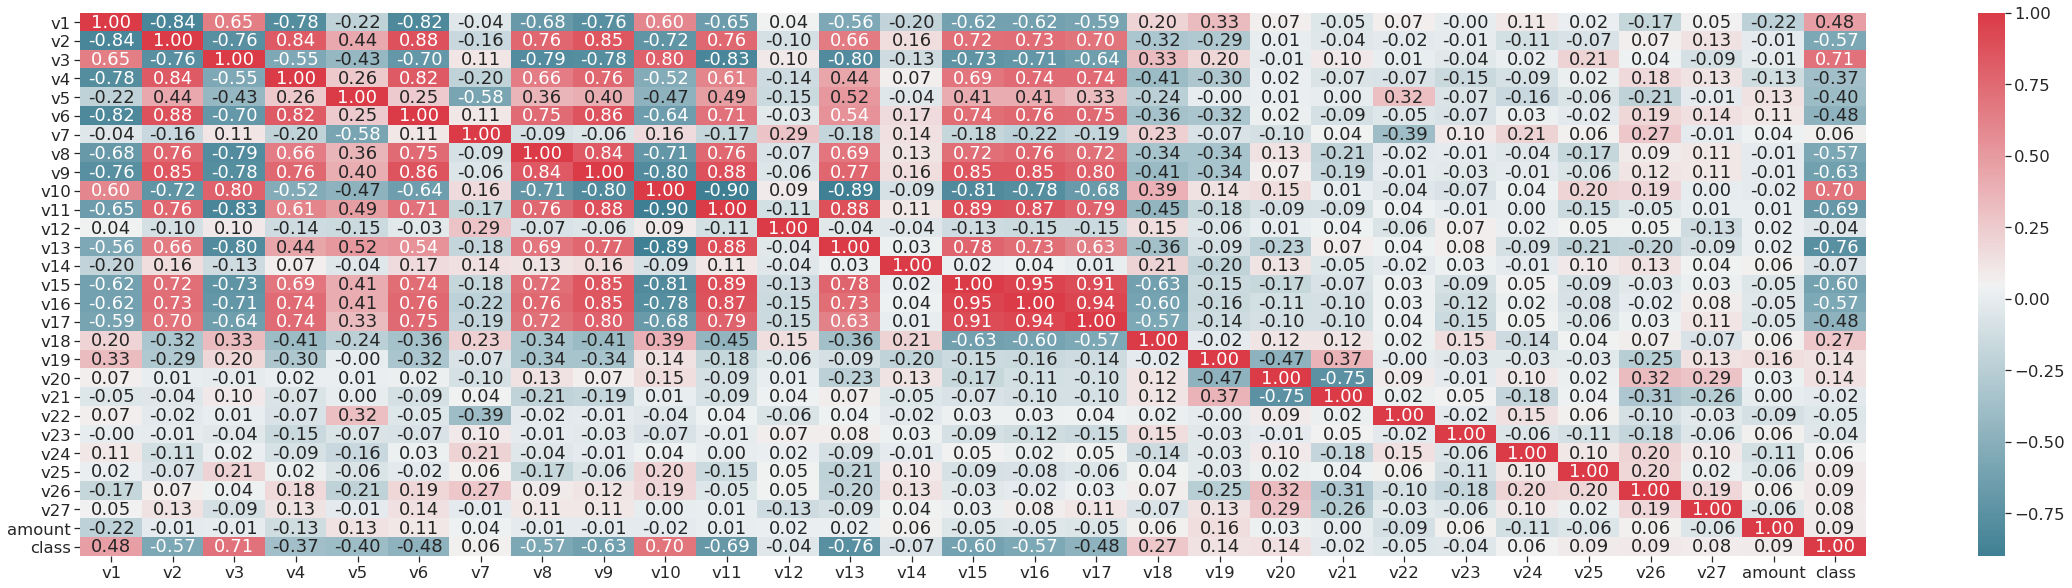

In [20]:
fig, ax1 = plt.subplots(1, figsize=(40,10))
corr = df_downsampled_train.corr() # Todo combinar con Y_train
sns.heatmap(corr, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f")
sns.set(font_scale=0.9)

##### Conclusiones

- **Correlación negativa**: v1, v3,v5,v6,v7,v9,v10,v12,v14,v16,v17,v18 tienen valores de correlación negativos. Valores negativos más extremos están correlacionados con mayor probabilidad de fraude.
- **Correlación positiva**: v2,v4,v11,v19 estan positivamente correlacionados. Los valores más altos indican mayor probabilidad de fraude.

Es de interés analizar como están distribuidos los valores de estas características para cada resultado de la clasificación.

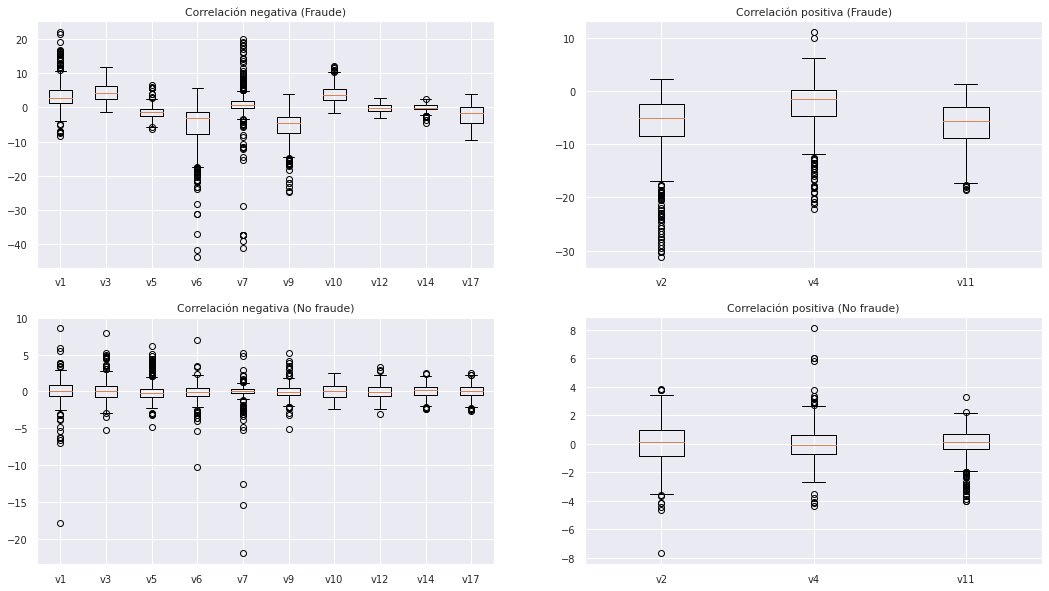

In [21]:
negative_corr = ['v1','v3','v5','v6','v7','v9','v10','v12','v14','v17']
positive_corr = ['v2','v4','v11']

pos_corr_plots_fraud = []
neg_corr_plots_fraud = []
pos_corr_plots_no_fraud = []
neg_corr_plots_no_fraud = []

for x in negative_corr:
    neg_corr_plots_fraud.append(df_downsampled_train.loc[df_downsampled_train['class']==1,x])
    neg_corr_plots_no_fraud.append(df_downsampled_train.loc[df_downsampled_train['class']==0,x])
    
for x in positive_corr:
    pos_corr_plots_fraud.append(df_downsampled_train.loc[df_downsampled_train['class']==1,x])
    pos_corr_plots_no_fraud.append(df_downsampled_train.loc[df_downsampled_train['class']==0,x])    

fig, axes = plt.subplots(2,2, figsize=(18,10))

axes[0][0].set_title("Correlación negativa (Fraude)")
axes[0][0].boxplot( neg_corr_plots_fraud )
axes[0][0].set_xticklabels(negative_corr)

axes[0][1].set_title("Correlación positiva (Fraude)")
axes[0][1].boxplot( pos_corr_plots_fraud )
axes[0][1].set_xticklabels(positive_corr)

axes[1][0].set_title("Correlación negativa (No fraude)")
axes[1][0].boxplot( neg_corr_plots_no_fraud)
axes[1][0].set_xticklabels(negative_corr)

axes[1][1].set_title("Correlación positiva (No fraude)")
axes[1][1].boxplot(pos_corr_plots_no_fraud)
axes[1][1].set_xticklabels(positive_corr)

plt.show()

Se puede observar en los diagramas anteriores si hay variables que tengan un bajo grado de solapamiento en sus distribuciones para cada una de las clases, sugiriendo que son candidatos a ser buenos clasificadores. Destacan las columnas v2, v4 y v11 (como ya se vió en los resultados de la correlación anterior).

### 1.3.2 Análisis por Random Forest

Otro método para obtener aquellas características que influyan más en el resultado es aprovechando la selección de parámetros que hace el algoritmo Random Forest.

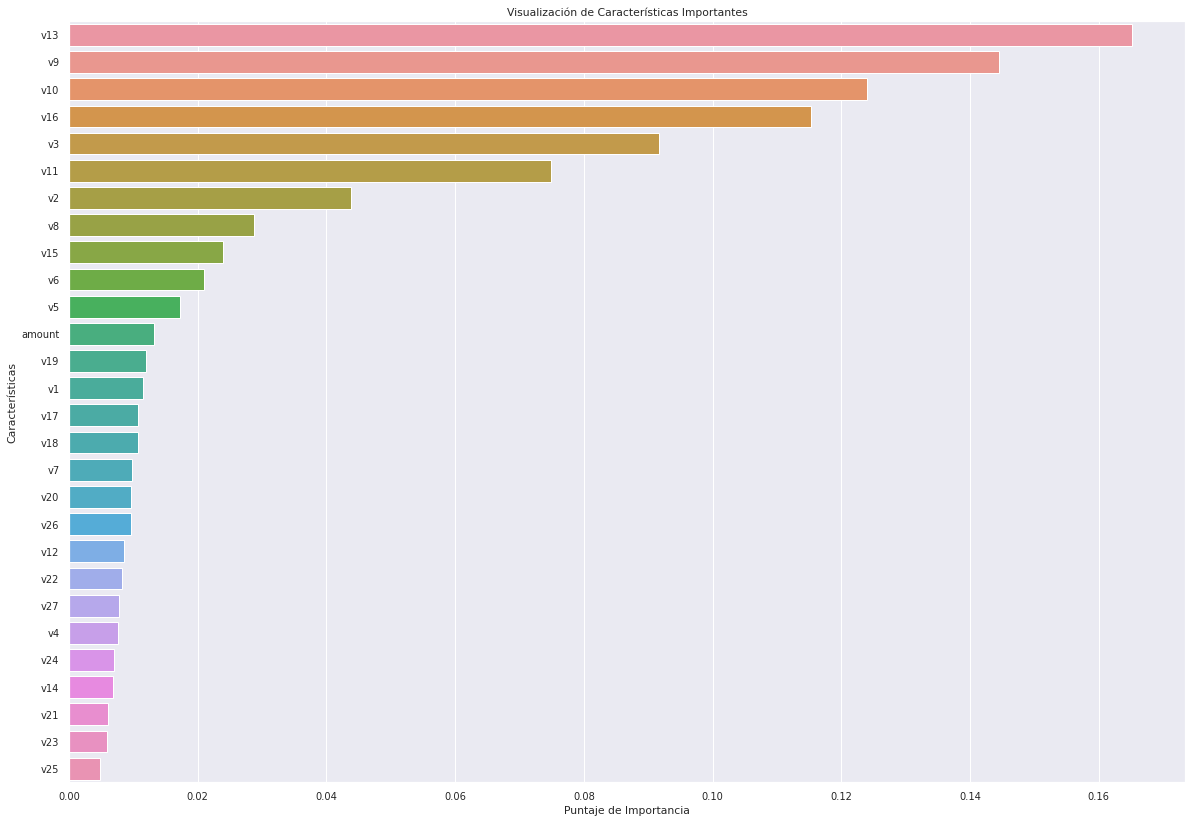

In [22]:
clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
clf.fit(X_train,y_train)

feature_imp = pd.Series(clf.feature_importances_,index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(20,14))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Puntaje de Importancia')
plt.ylabel('Características')
plt.title("Visualización de Características Importantes")
plt.show()

## 1.4 Conclusiones y lineamientos para desarrollo de modelos

- Se observó que el dataset está fuertemente desbalanceado y se continuó el ánalisis sobre un dataset reducido para balancear las muestras de cada clase. 
- Se identificaron las características más sobresalientes.
- Se estudió la reducción de dimensiones. Si bien K-Means no dió buenos resultados aquí, en dos dimensiones hay una separación evidente que parece podría dar buenos resultados para un algoritmo que trace un hiperplano paralelo al eje X entre 0 y -10.